Looking at SQ stock vs a list of peers.

In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

stock_list = ['SQ','FIS','FISV','ADP','PAYX','GPN']  #list of peers

#helper functions

def get_price_data(ticker):
    price_data = si.get_data(ticker,start_date = '01/01/2009')
    df = pd.DataFrame(price_data)
    df = df[['adjclose']]
    df['pct_change'] = df.adjclose.pct_change()
    df['log_return'] = np.log(1 + df['pct_change'].astype(float))
    df['ticker'] = ticker
    return df

def get_portfolio_return(df,list_stocks,n):
    df = df.iloc[-n:,].copy()
    for col in df.columns:
        if col in list_stocks:
            df[col+'_cmltv_ret'] = np.exp(np.log1p(df[col]).cumsum())-1
    list_cols = []
    for col in df.columns:
        if 'cmltv' in col and 'SPY' not in col:
            list_cols.append(col)
    df['portfolio_return'] = df[list_cols].mean(axis=1)
    return df

def get_betas(x,y,n=0):
    if n > 0:
        x = x.iloc[-n:,]
        y = y.iloc[-n:,]
    res = sm.OLS(y, x).fit()
    ticker = col.split('_')[0]
    beta = res.params[0]
    r2 = res.rsquared
    n = len(x)
    return [beta,r2,n]

list_df = []
for item in stock_list:
    df = get_price_data(item)
    list_df.append(df)



In [2]:
#convert from long data to wide

df_long = pd.concat(list_df,axis = 0).reset_index()
df_wide = df_long.pivot_table(index=["index"],
                    columns='ticker',
                    values='pct_change')

spy = get_price_data('SPY').reset_index()

dataset = pd.merge(spy,df_wide,how = 'inner',left_on='index',right_on='index')

betas = {}
ns = {}
r2s = {}
for col in dataset.columns:
    if col in stock_list:
        df = dataset[['pct_change',col]].dropna()
        beta,r2,n = get_betas(df['pct_change'],df[col])
        betas[col]=beta
        ns[col]=n
        r2s[col]=r2

vs the S&P, my calculated BETA shows a fairly tight clustering except for SQ which really isn't in this comp group from a risk management perspective 

In [3]:
 {k: v for k, v in sorted(betas.items(), key=lambda item: item[1])}

{'ADP': 0.9444234258466725,
 'FIS': 0.9564460299136511,
 'PAYX': 0.9685098296394691,
 'FISV': 1.0111448899762885,
 'GPN': 1.1022124249307723,
 'SQ': 1.5988839668022679}

In [5]:
dataset_stocks = dataset.drop(columns = ['adjclose','pct_change','log_return','ticker'])
portfolio_return = get_portfolio_return(dataset_stocks,stock_list,n=252)
spy_return = get_portfolio_return(dataset[['pct_change']],'pct_change',n=252)
spy_return = spy_return.drop(columns = ['pct_change','pct_change_cmltv_ret'])
spy_return.columns = ['SPY_return']

SQ has obviously massively outperformed the group.

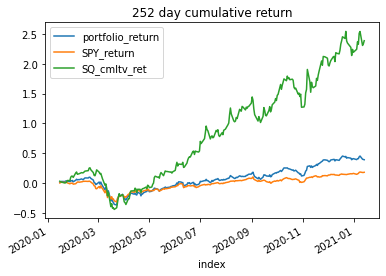

In [44]:
df_plot = pd.concat([portfolio_return,spy_return],axis = 1)
df_plot.set_index('index')[['portfolio_return','SPY_return','SQ_cmltv_ret']].plot(title = '252 day cumulative return')

For purposes of attempting to decompose how it trades, I assembled a group of ETFs and stocks which can act as thematic proxies.  I put AMZN in as a "covid proxy" which is a way of saying people are locked in their houses and buying stuff online.  I'm using FXI as a "china proxy" and USO as an "oil proxy" etc.  Of course we don't expect SQ to trade with oil but in the case of bank stocks this sometimes shows up as a good factor to watch.

I'm using MSTR as a BITCOIN proxy

In [26]:

#single stock analysis
# TLT bonds
# MSTR bitcoin proxy
# SPY s&p proxy
# V payments proxy
# GPN payments proxy
# FXI china proxy
# USO oil proxy
# AMZN covid proxy

betas_list = ['TLT','MSTR','SPY','V','GPN','FXI','USO','AMZN']

list_df = []
for item in betas_list:
    df = get_price_data(item)
    list_df.append(df)

df_long = pd.concat(list_df,axis = 0).reset_index()
df_wide = df_long.pivot_table(index=["index"],
                    columns='ticker',
                    values='pct_change')

df_sq = get_price_data('SQ').reset_index()

dataset = pd.merge(df_sq,df_wide,how = 'inner',left_on='index',right_on='index')

beta_lens = [60,90,252] #window for betas
dict_lens = {}
for beta_len in beta_lens:
    betas = {}
    ns = {}
    r2s = {}
    for col in dataset.columns:
        if col in betas_list:
            df = dataset[['pct_change',col]].dropna()
            beta,r2,n = get_betas(df['pct_change'],df[col],beta_len)
            betas[col]=beta
            ns[col]=n
            r2s[col]=r2
    dict_lens[beta_len] = [betas,ns,r2s]


60
90
252


In [ ]:
Running an OLS over this group on different windows (we can do sliding windows but a discrete approach is quicker to code) of 60 days, 90 days, and 252 days (approx a year) you see how SQ trading characteristics have shifted.

To be sure, most stocks have low R2 with exogenous indicators - this is why they're stocks not bonds - but the chart below shows something interesting:
SQ has been a steady correlation with AMZN.
SQ WAS a HIGHER correlation with GPN and V a year ago.  That association has plunged.
SQ WAS a higher correlation with the bitcoin proxy MSTR than it is now.  Bitcoin isn't what drives this stock.
SQ association with the market has decoupled similar to its association with V and GPN.
Oil and China don't matter and never have.

In [36]:
df1 = pd.DataFrame.from_dict(dict_lens[60][2],orient='index').reset_index()
df1.columns = ['TICKER','R2_60']
df2 = pd.DataFrame.from_dict(dict_lens[90][2],orient='index').reset_index()
df2.columns = ['TICKER','R2_90']
df3 = pd.DataFrame.from_dict(dict_lens[252][2],orient='index').reset_index()
df3.columns = ['TICKER','R2_252']
df = pd.merge(df1,df2)
df = pd.merge(df,df3)
df

,TICKER,R2_60,R2_90,R2_252
0,AMZN,0.282717,0.318416,0.262031
1,FXI,0.107940,0.084861,0.329059
2,GPN,0.012038,0.000224,0.381622
3,MSTR,0.031924,0.040732,0.101316
4,SPY,0.077642,0.161856,0.445204
5,TLT,0.049586,0.015757,0.045320
6,USO,0.004097,0.016615,0.062705
7,V,0.007876,0.043854,0.401320


Bottom line: SQ trades like a COVID proxy, I'd use AMZN or some similar stock to hedge it, and would expect SQ to revert to its year-ago trading pattern if lockdowns ended.

An extension of this analysis would look at the cointegration between AMZN and SQ and establish the hedge ratio and current trading separation for the proper entry point and size of hedge.  An example of this is on my blog "Simple Pair Trading Example with Python" down towards the bottom of the blog main page.  The blog link is below (I haven't updated it in a year or so as I've been so busy with Zoominfo).

https://jedgore.wordpress.com/page/3/
